In [66]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Masking
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import pytz

In [61]:
conn = sqlite3.connect(r'E:\Oppermann\MAEOPP\Database\pv_forecast.db')

query = f"""
SELECT "Date time", Location, shortwave_radiation, Temperature, AOI, "Cloud Cover", "Relative Humidity", "Wind Speed", "kW/kWp"
FROM pv_weather_data
ORDER BY Location, "Date time" ASC
"""
# Daten abrufen und in ein DataFrame laden
df = pd.read_sql(query, conn)
conn.close()

# Ausgabe des DataFrames zum Überprüfen


print("Anzahl NaN-Werte pro Spalte:\n", df.isna().sum())

# Falls es NaN-Werte gibt, betroffene Zeilen anzeigen
if df.isna().sum().sum() > 0:
    print("\nZeilen mit NaN-Werten:")
    print(df[df.isna().any(axis=1)])

Anzahl NaN-Werte pro Spalte:
 Date time              0
Location               0
shortwave_radiation    0
Temperature            0
AOI                    0
Cloud Cover            0
Relative Humidity      0
Wind Speed             0
kW/kWp                 0
dtype: int64


In [62]:
def get_sliding_window(df, datetime_col, feature_cols, target_col, window_size=192, forecast_horizon=96, step_size=1):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col).reset_index(drop=True)

    feature_data = df[feature_cols].values
    target_data = df[target_col].values
    datetime_data = df[datetime_col].values

    X, y, timestamps = [], [], []

    for i in range(0, len(df) - window_size - forecast_horizon, step_size):
        X_seq = feature_data[i : i + window_size].copy()

        X_seq[-forecast_horizon:, -1] = -1

        y_seq = target_data[i + window_size - forecast_horizon : i + window_size]
        ts_seq = datetime_data[i + window_size - forecast_horizon : i + window_size]

        X.append(X_seq)  # Input-Sequenz
        y.append(y_seq)  # Zielwerte
        timestamps.append(ts_seq)
        
    return np.array(X), np.array(y), np.array(timestamps)

In [ ]:
feature_cols = ["shortwave_radiation", "Temperature", "AOI", "Cloud Cover", "Relative Humidity", "Wind Speed", "relative_efficiency", "kW/kWp", "kW/kWp_pvlib"]
target_col = "kW/kWp"

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

df[feature_cols] = feature_scaler.fit_transform(df[feature_cols])
df[target_col] = target_scaler.fit_transform(df[[target_col]])


X_list, y_list, timestamp_list = [], [], []
location_ids = []


for location in df["Location"].unique():
    print(f"Erstelle Sliding Windows für {location}...")

    df_location = df[df["Location"] == location].copy()

    X, y, ts = get_sliding_window(df_location, datetime_col="Date time", feature_cols=feature_cols, target_col=target_col)

    X_list.append(X)
    y_list.append(y)
    timestamp_list.append(ts)
    

    location_ids.extend([location] * len(X))

X_final = np.concatenate(X_list, axis=0)  # Alle Input-Sequenzen
y_final = np.concatenate(y_list, axis=0)  # Alle Zielwerte
timestamps_final = np.concatenate(timestamp_list, axis=0)

location_ids = np.array(location_ids)

np.save("X_tensor.npy", X_final)
np.save("y_tensor.npy", y_final)
np.save("timestamps.npy", timestamps_final)
np.save("location_ids.npy", location_ids)

print(f"Finaler Tensor X Shape: {X_final.shape}")  # (Samples, Timesteps=672, Features=3)
print(f"Finaler Tensor y Shape: {y_final.shape}")  # (Samples, Forecast_Horizon=96)
print(f"Timestamps shape: {timestamps_final.shape}")
print(f"Finaler Tensor location.ids-Shape: {location_ids.shape}")

Erstelle Sliding Windows für bielefeldmel...
Erstelle Sliding Windows für bielefeldref...
Erstelle Sliding Windows für gaithersburg...
Erstelle Sliding Windows für hongkong...
Erstelle Sliding Windows für istanbul...
Erstelle Sliding Windows für victoria14...
Erstelle Sliding Windows für victoria15...
Erstelle Sliding Windows für victoria16...
Erstelle Sliding Windows für victoria17...
Finaler Tensor X Shape: (440599, 192, 7)
Finaler Tensor y Shape: (440599, 96)
Timestamps shape: (440599, 96)
Finaler Tensor location.ids-Shape: (440599,)


In [64]:
X_temp, X_test, y_temp, y_test, loc_temp, loc_test, timestamps_temp, timestamps_test  = train_test_split(
    X_final, y_final, location_ids, timestamps_final,
    test_size=0.15,
    stratify=location_ids,
    random_state=42)

In [ ]:
X_temp, X_test, y_temp, y_test, loc_temp, loc_test, timestamps_temp, timestamps_test  = train_test_split(
    X_final, y_final, location_ids, timestamps_final
    test_size=0.15,
    stratify=location_ids,
    random_state=42)


gkf = GroupKFold(n_splits=9)

fold_results = []


for fold, (train_idx, val_idx) in enumerate(gkf.split(X_temp, y_temp, groups=loc_temp)):
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp[train_idx], y_temp[val_idx]

    batch_size=32
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    model = Sequential([
        Masking(mask_value=-1, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(32, activation="tanh", return_sequences=True),
        LSTM(64, activation="tanh"),
        Dense(96, activation='sigmoid')  
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['mae'])

    history = model.fit(
        train_dataset,
        epochs=20,
        batch_size=batch_size,
        validation_data= val_dataset,
        verbose=1)
    
    fold_results.append(history.history)

    
avg_loss = np.mean([min(history['val_loss']) for history in fold_results])
print(f"Durchschnittlicher Validierungsverlust: {avg_loss:.4f}")

Epoch 1/20


c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9774/9774 ━━━━━━━━━━━━━━━━━━━━ 1671s 170ms/step - loss: 0.0182 - mae: 0.0822 - val_loss: 0.0175 - val_mae: 0.0691
Epoch 2/20
9774/9774 ━━━━━━━━━━━━━━━━━━━━ 1486s 152ms/step - loss: 0.0086 - mae: 0.0481 - val_loss: 0.0165 - val_mae: 0.0649
Epoch 3/20
9774/9774 ━━━━━━━━━━━━━━━━━━━━ 1487s 152ms/step - loss: 0.0076 - mae: 0.0447 - val_loss: 0.0158 - val_mae: 0.0638
Epoch 4/20
9774/9774 ━━━━━━━━━━━━━━━━━━━━ 1407s 144ms/step - loss: 0.0066 - mae: 0.0407 - val_loss: 0.0177 - val_mae: 0.0675
Epoch 5/20
9774/9774 ━━━━━━━━━━━━━━━━━━━━ 1510s 155ms/step - loss: 0.0062 - mae: 0.0386 - val_loss: 0.0189 - val_mae: 0.0675
Epoch 6/20
9774/9774 ━━━━━━━━━━━━━━━━━━━━ 1519s 155ms/step - loss: 0.0059 - mae: 0.0370 - val_loss: 0.0181 - val_mae: 0.0656
Epoch 7/20
9774/9774 ━━━━━━━━━━━━━━━━━━━━ 1522s 156ms/step - loss: 0.0057 - mae: 0.0359 - val_loss: 0.0197 - val_mae: 0.0708
Epoch 8/20
9774/9774 ━━━━━━━━━━━━━━━━━━━━ 1528s 156ms/step - loss: 0.0055 - mae: 0.0351 - val_loss: 0.0181 - val_mae: 0.0673
Epoch 9/20


In [35]:
train_avg_loss = np.mean([min(history['loss']) for history in fold_results])
print(f"Durchschnittlicher Trainingssverlust: {train_avg_loss:.4f}")

Durchschnittlicher Trainingssverlust: 0.0044


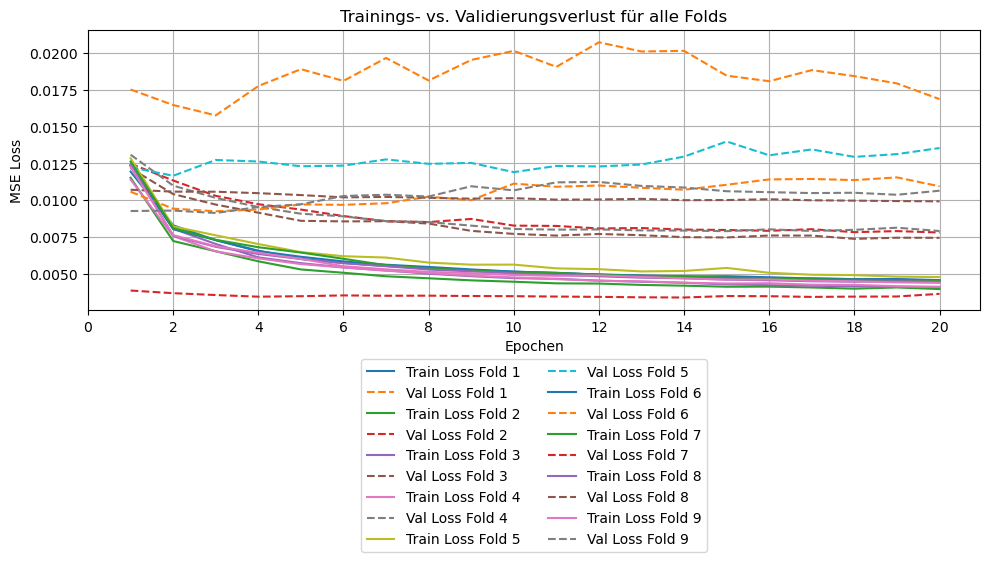

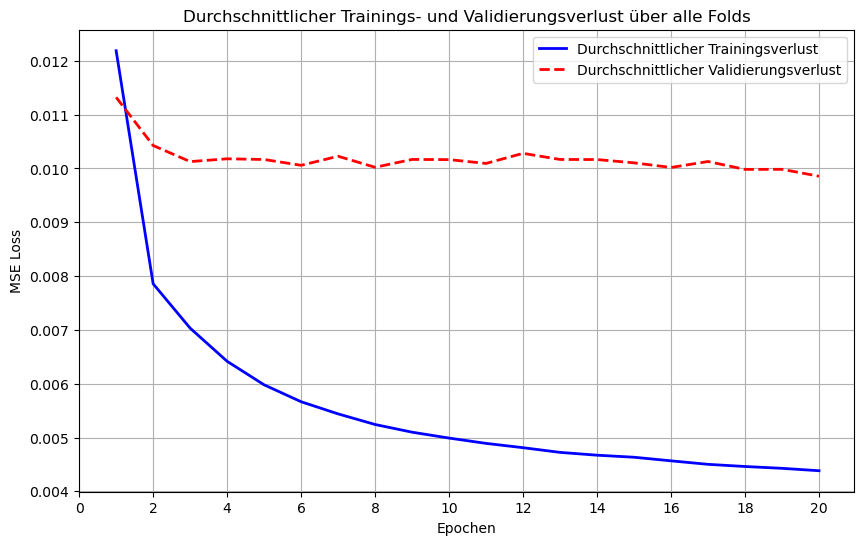

In [31]:
num_epochs = len(fold_results[0]['loss'])
avg_train_loss = np.zeros(num_epochs)
avg_val_loss = np.zeros(num_epochs)

for history in fold_results:
    avg_train_loss += np.array(history['loss'])
    avg_val_loss += np.array(history['val_loss'])

avg_train_loss /= len(fold_results)
avg_val_loss /= len(fold_results)

plt.figure(figsize=(10, 6))
for fold, history in enumerate(fold_results):
    plt.plot(range(1, 21), history['loss'], label=f"Train Loss Fold {fold+1}")
    plt.plot(range(1, 21), history['val_loss'], linestyle="--", label=f"Val Loss Fold {fold+1}")

plt.xlabel("Epochen")
plt.xticks(np.arange(0, 22, 2))
plt.ylabel("MSE Loss")
plt.title("Trainings- vs. Validierungsverlust für alle Folds")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), avg_train_loss, color="blue", linewidth=2, label="Durchschnittlicher Trainingsverlust")
plt.plot(range(1, 21), avg_val_loss, color="red", linewidth=2, linestyle="--", label="Durchschnittlicher Validierungsverlust")

plt.xlabel("Epochen")
plt.xticks(np.arange(0, 22, 2))
plt.ylabel("MSE Loss")
plt.title("Durchschnittlicher Trainings- und Validierungsverlust über alle Folds")
plt.legend()
plt.grid()
plt.show()

In [32]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_loss, test_mae = model.evaluate(test_dataset)
test_rmse = np.sqrt(test_loss)

print(f"\n Finaler Testverlust (MSE): {test_loss:.4f}")
print(f"\n Finaler Testverlust (RMSE): {test_rmse:.4f}")
print(f"Finaler Test-MAE: {test_mae:.4f}")

2066/2066 ━━━━━━━━━━━━━━━━━━━━ 83s 40ms/step - loss: 0.0049 - mae: 0.0320

 Finaler Testverlust (MSE): 0.0048

 Finaler Testverlust (RMSE): 0.0696
Finaler Test-MAE: 0.0319


In [39]:
print(len(X_test), len(y_test), len(loc_test))

66090 66090 66090


In [42]:
unique_anlagen = np.unique(loc_test)

print("\nFehlermetriken pro Anlage:")
for anlage in unique_anlagen:
    # Filtere Daten für diese Anlage
    indices = np.where(loc_test == anlage)[0]
    X_anlage = X_test[indices]
    y_anlage = y_test[indices]

    # Baue Dataset
    dataset_anlage = tf.data.Dataset.from_tensor_slices((X_anlage, y_anlage)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Evaluate
    loss_anlage, mae_anlage = model.evaluate(dataset_anlage, verbose=0)
    rmse_anlage = np.sqrt(loss_anlage)

    print(f"Anlage {anlage}: MSE = {loss_anlage:.4f} , RMSE = {rmse_anlage:.4f}, MAE = {mae_anlage:.4f}")


Fehlermetriken pro Anlage:
Anlage bielefeldmel: MSE = 0.0036 , RMSE = 0.0601, MAE = 0.0322
Anlage bielefeldref: MSE = 0.0026 , RMSE = 0.0508, MAE = 0.0237
Anlage gaithersburg: MSE = 0.0106 , RMSE = 0.1030, MAE = 0.0537
Anlage hongkong: MSE = 0.0033 , RMSE = 0.0575, MAE = 0.0267
Anlage istanbul: MSE = 0.0025 , RMSE = 0.0496, MAE = 0.0219
Anlage victoria14: MSE = 0.0062 , RMSE = 0.0788, MAE = 0.0360
Anlage victoria15: MSE = 0.0060 , RMSE = 0.0775, MAE = 0.0352
Anlage victoria16: MSE = 0.0021 , RMSE = 0.0460, MAE = 0.0219
Anlage victoria17: MSE = 0.0063 , RMSE = 0.0794, MAE = 0.0365


In [33]:
model.save("lstm_first_run.keras")
print("Modell wurde gespeichert.")

Modell wurde gespeichert.


In [34]:
print("Train-Gruppen:", np.unique(loc_temp))
print("Test-Gruppen:", np.unique(loc_test))

Train-Gruppen: ['bielefeldmel' 'bielefeldref' 'gaithersburg' 'hongkong' 'istanbul'
 'victoria14' 'victoria15' 'victoria16' 'victoria17']
Test-Gruppen: ['bielefeldmel' 'bielefeldref' 'gaithersburg' 'hongkong' 'istanbul'
 'victoria14' 'victoria15' 'victoria16' 'victoria17']


2066/2066 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step


c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squ

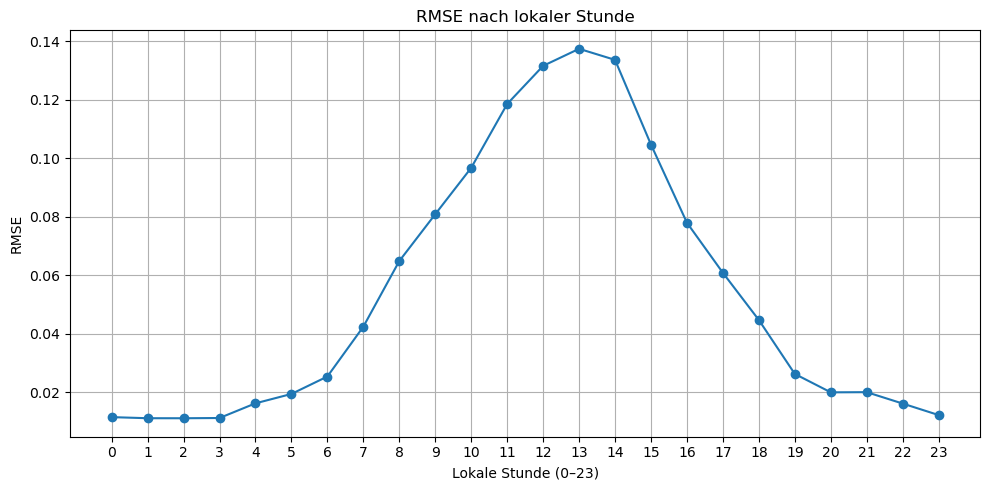

In [71]:
y_pred = model.predict(X_test)


df_eval = pd.DataFrame({
    'timestamp': timestamps_test.flatten(),
    'y_true': y_test.flatten(),
    'y_pred': y_pred.flatten(),
    "location": np.repeat(loc_test, y_test.shape[1])
})

location_timezone_map = {
    "bielefeldmel": "Europe/Berlin",
    "bielefeldref": "Europe/Berlin",
    "gaithersburg": "America/New_York",
    "hongkong": "Asia/Hong_Kong",
    "istanbul": "Europe/Istanbul",
    "victoria14": "Australia/Melbourne",
    "victoria15": "Australia/Melbourne",
    "victoria16": "Australia/Melbourne",
    "victoria17": "Australia/Melbourne",
}

def convert_to_local_hour(row):
    tz = pytz.timezone(location_timezone_map[row["location"]])
    utc_time = (row["timestamp"]).tz_localize("UTC")
    local_time = utc_time.astimezone(tz)
    return local_time.hour

df_eval["hour_local"] = df_eval.apply(convert_to_local_hour, axis=1)

rmse_per_hour = df_eval.groupby("hour_local").apply(
    lambda g: mean_squared_error(g["y_true"], g["y_pred"], squared=False)
)

# Plot
plt.figure(figsize=(10, 5))
rmse_per_hour.sort_index().plot(marker="o")
plt.title("RMSE nach lokaler Stunde")
plt.xlabel("Lokale Stunde (0–23)")
plt.ylabel("RMSE")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lab50Stud3\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squ

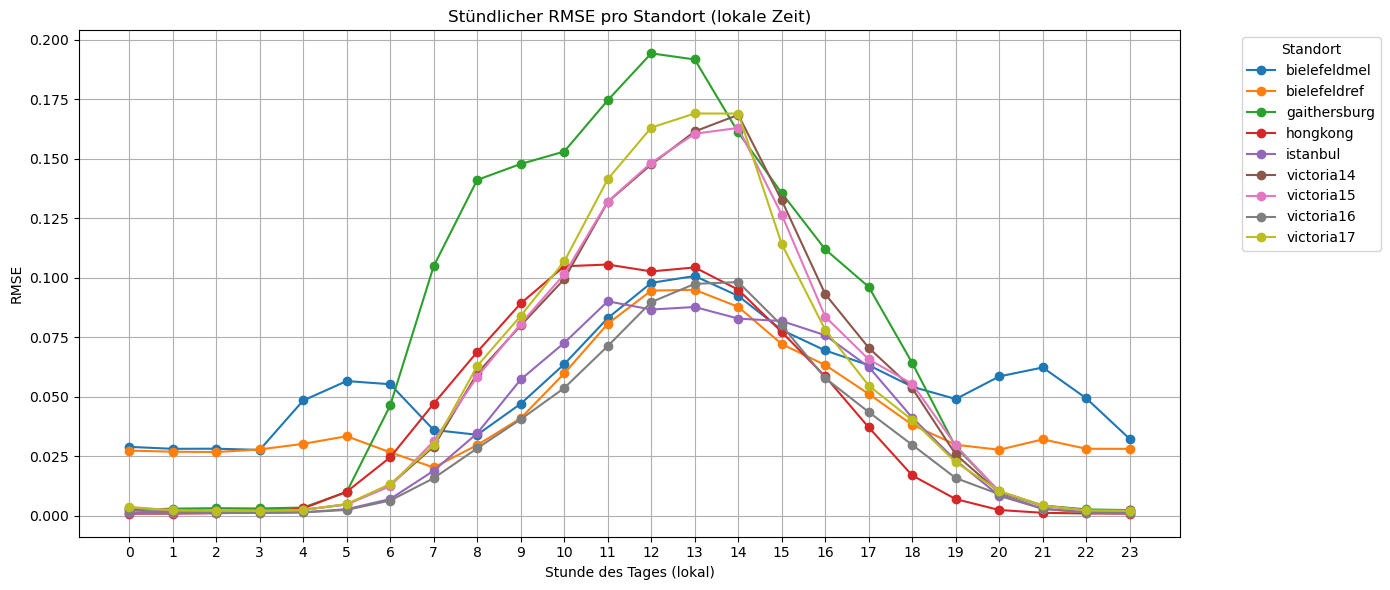

In [74]:
rmse_by_location_hour = df_eval.groupby(["location", "hour_local"]).apply(
    lambda g: mean_squared_error(g["y_true"], g["y_pred"], squared=False)
).unstack()

plt.figure(figsize=(14, 6))

for location in rmse_by_location_hour.index:
    plt.plot(
        rmse_by_location_hour.columns,
        rmse_by_location_hour.loc[location],
        marker='o',
        label=location
    )

plt.title("Stündlicher RMSE pro Standort (lokale Zeit)")
plt.xlabel("Stunde des Tages (lokal)")
plt.ylabel("RMSE")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title="Standort", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

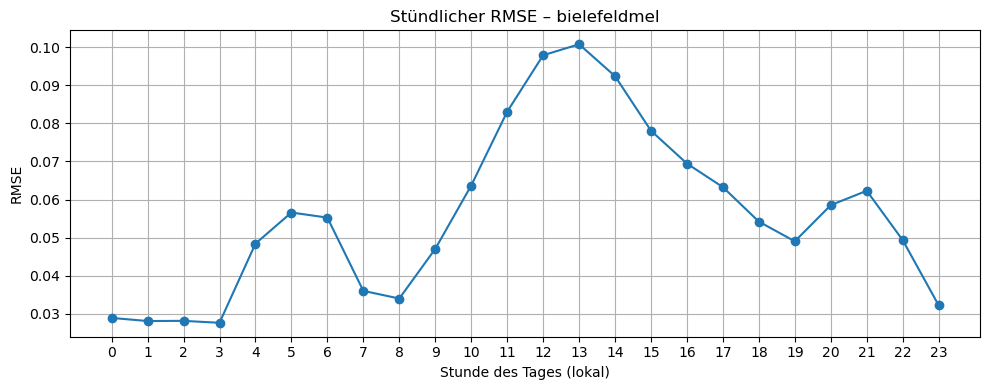

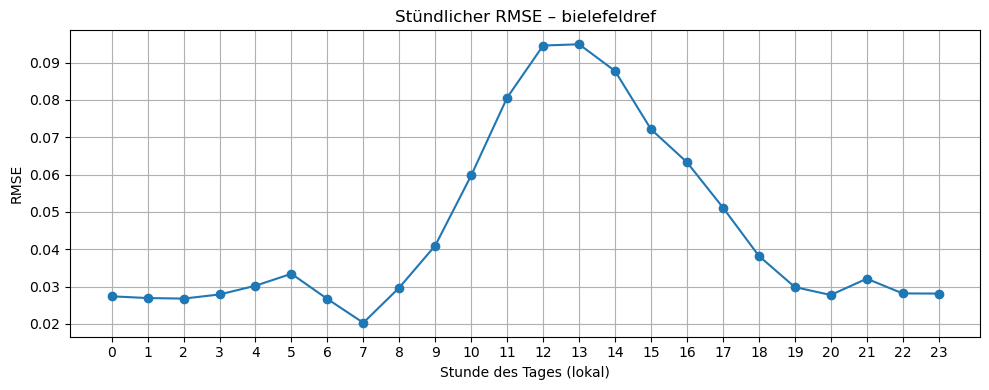

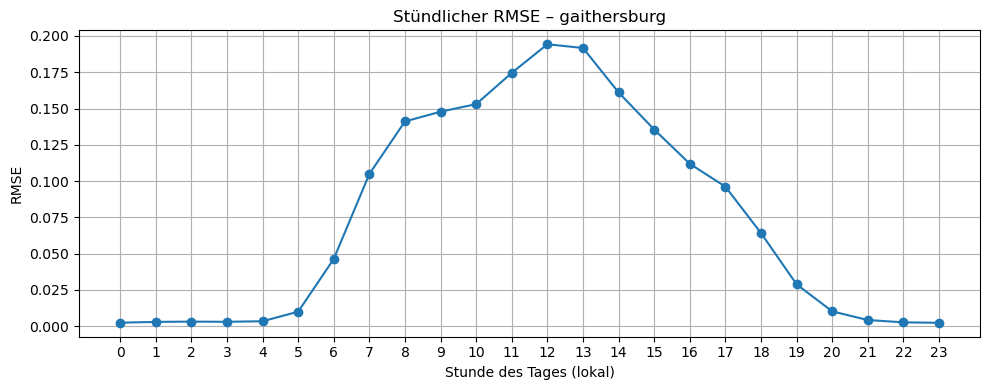

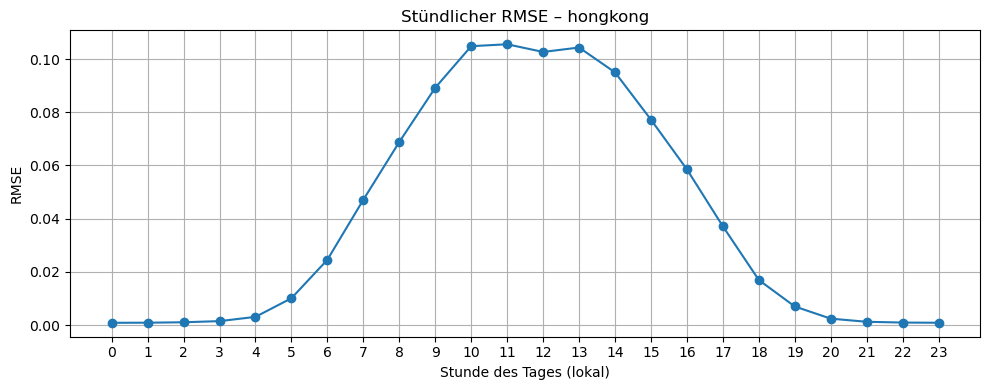

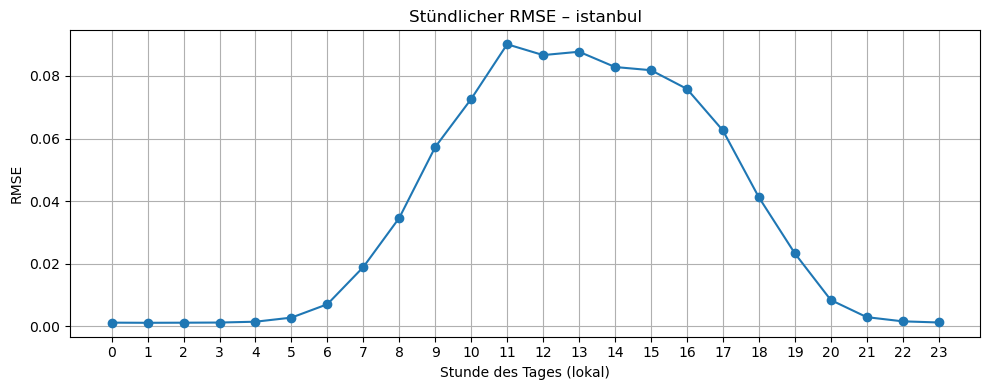

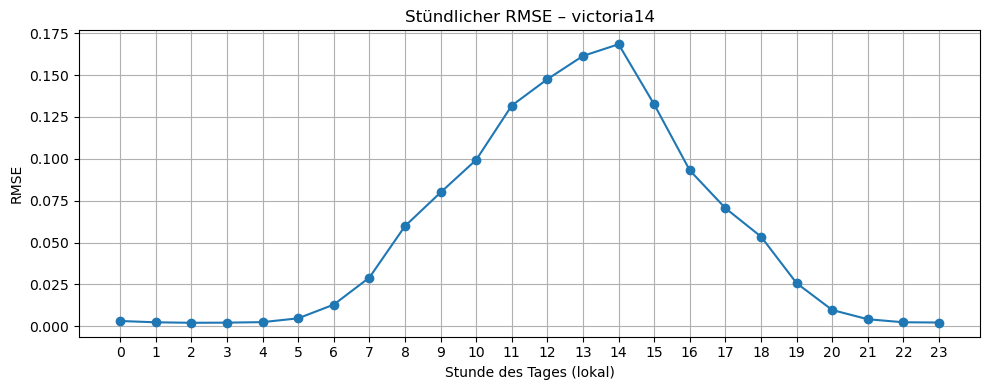

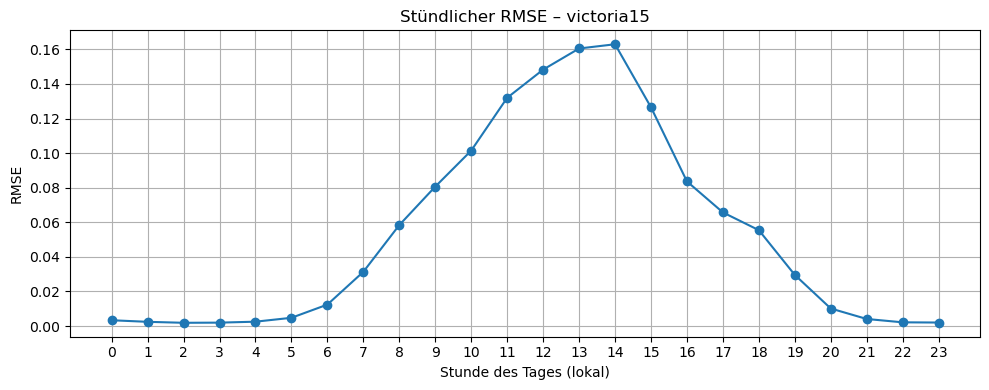

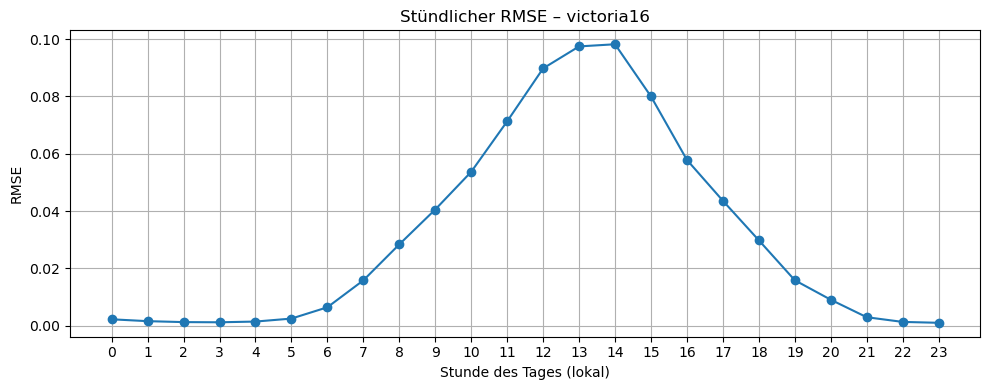

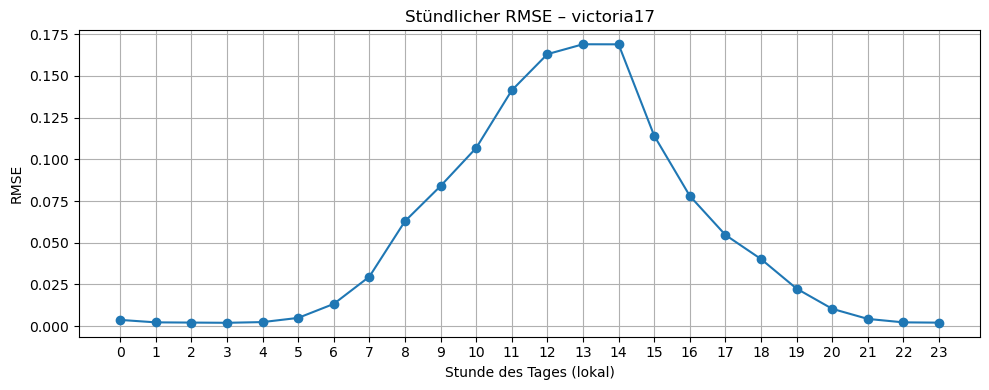

In [75]:
locations = rmse_by_location_hour.index

for location in locations:
    plt.figure(figsize=(10, 4))
    plt.plot(
        rmse_by_location_hour.columns,             # Stunden 0–23
        rmse_by_location_hour.loc[location],       # RMSE-Werte
        marker='o'
    )
    plt.title(f"Stündlicher RMSE – {location}")
    plt.xlabel("Stunde des Tages (lokal)")
    plt.ylabel("RMSE")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()